# A Network Tour of Data Science

[Michaël Defferrard](http://deff.ch), *PhD student*, [Pierre Vandergheynst](https://people.epfl.ch/pierre.vandergheynst), *Full Professor*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch).

# Exercise 5: Graph Signals and Fourier Transform

The goal of this exercise is to experiment with the notions of graph signals, graph Fourier transform and smoothness and illustrate these concepts in the light of clustering.

In [1]:
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

## 1 Graph

**Goal**: compute the combinatorial Laplacian $L$ of a graph formed with $c=2$ clusters.

**Step 1**: construct and visualize a fabricated data matrix $X = [x_1, \ldots, x_n]^t \in \mathbb{R}^{n \times d}$ whose lines are $n$ samples embedded in a $d$-dimensional Euclidean space.

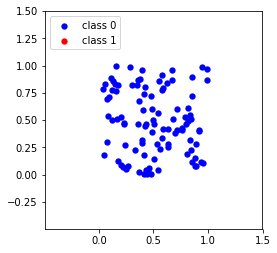

In [2]:
d = 2    # Dimensionality.
n = 100  # Number of samples.
c = 1    # Number of communities.

# Data matrix, structured in communities.
X = np.random.uniform(0, 1, (n, d))
X += np.linspace(0, 2, c).repeat(n//c)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, squeeze=True)
ax.scatter(X[:n//c, 0], X[:n//c, 1], c='b', s=40, linewidths=0, label='class 0');
ax.scatter(X[n//c:, 0], X[n//c:, 1], c='r', s=40, linewidths=0, label='class 1');
lim1 = X.min() - 0.5
lim2 = X.max() + 0.5
ax.set_xlim(lim1, lim2)
ax.set_ylim(lim1, lim2)
ax.set_aspect('equal')
ax.legend(loc='upper left');

**Step 2**: compute all $n^2$ pairwise euclidean distances $\operatorname{dist}(i, j) = \|x_i - x_j\|_2$.

Hint: you may use the function `scipy.spatial.distance.pdist()` and `scipy.spatial.distance.squareform()`.

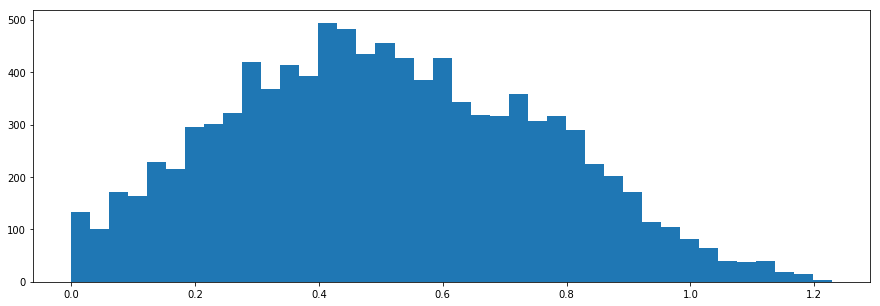

In [3]:
# Pairwise distances.
dist = scipy.spatial.distance.pdist(X, metric='euclidean')
dist = scipy.spatial.distance.squareform(dist)

plt.figure(figsize=(15, 5))
plt.hist(dist.flatten(), bins=40);

Step 3: order the distances and, for each sample, solely keep the $k=10$ closest samples to form a $k$ nearest neighbor ($k$-NN) graph.

Hint: you may sort a numpy array with `np.sort() or np.argsort()`.

In [4]:
k = 10  # Miminum number of edges per node.

idx = np.argsort(dist)[:, 1:k+1]
dist.sort()
dist = dist[:, 1:k+1]
assert dist.shape == (n, k)

Step 4: compute the weights using a Gaussian kernel, i.e. $$\operatorname{weight}(i, j) = \exp\left(-\frac{\operatorname{dist}(i,j)^2}{\sigma^2}\right) = \exp\left(-\frac{\|x_i - x_j\|_2^2}{\sigma^2}\right).$$

Hint: you may use the below definition of $\sigma^2$.

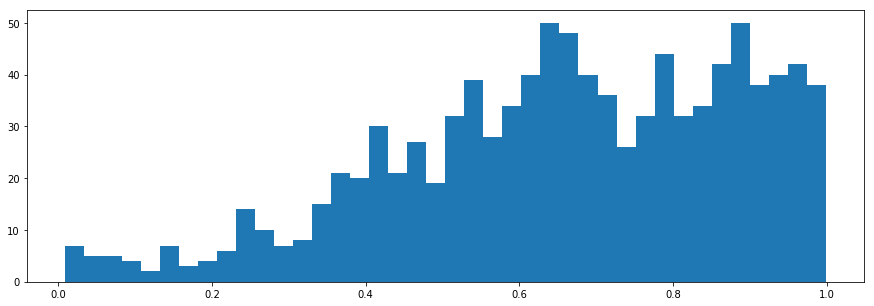

In [5]:
# Scaling factor.
sigma2 = np.mean(dist[:, -1])**2

# Weights with Gaussian kernel.
dist = np.exp(- dist**2 / sigma2)

plt.figure(figsize=(15, 5))
plt.hist(dist.flatten(), bins=40);

Step 5: construct and visualize the sparse weight matrix $W_{ij} = \operatorname{weight}(i, j)$.

Hint: you may use the function `scipy.sparse.coo_matrix()` to create a sparse matrix.

n = |V| = 100, k|V| < |E| = 1176


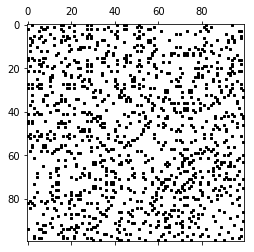

In [6]:
# Weight matrix.
I = np.arange(0, n).repeat(k)
J = idx.reshape(n*k)
V = dist.reshape(n*k)
W = scipy.sparse.coo_matrix((V, (I, J)), shape=(n, n))

# No self-connections.
W.setdiag(0)

# Non-directed graph.
bigger = W.T > W
W = W - W.multiply(bigger) + W.T.multiply(bigger)
assert type(W) == scipy.sparse.csr_matrix

print('n = |V| = {}, k|V| < |E| = {}'.format(n, W.nnz))
plt.spy(W, markersize=2, color='black');

import scipy.io
import os.path
scipy.io.mmwrite(os.path.join('datasets', 'graph_inpainting', 'embedding.mtx'), X)
scipy.io.mmwrite(os.path.join('datasets', 'graph_inpainting', 'graph.mtx'), W)

Step 6: compute the combinatorial graph Laplacian $L = D - W$ where $D$ is the diagonal degree matrix $D_{ii} = \sum_j W_{ij}$.

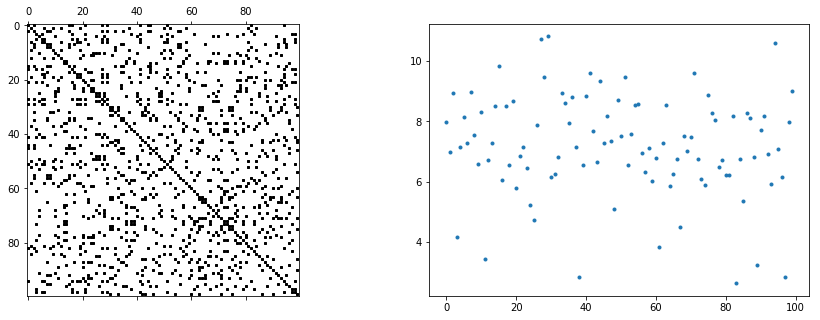

In [7]:
# Degree matrix.
D = W.sum(axis=0)
D = scipy.sparse.diags(D.A.squeeze(), 0)

# Laplacian matrix.
L = D - W

fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(15, 5))
axes[0].spy(L, markersize=2, color='black');
axes[1].plot(D.diagonal(), '.');

## 2 Fourier Basis

Compute the eigendecomposition $L=U \Lambda U^t$ of the Laplacian, where $\Lambda$ is the diagonal matrix of eigenvalues $\Lambda_{\ell\ell} = \lambda_\ell$ and $U = [u_1, \ldots, u_n]^t$ is the graph Fourier basis.

Hint: you may use the function `np.linalg.eigh()`.

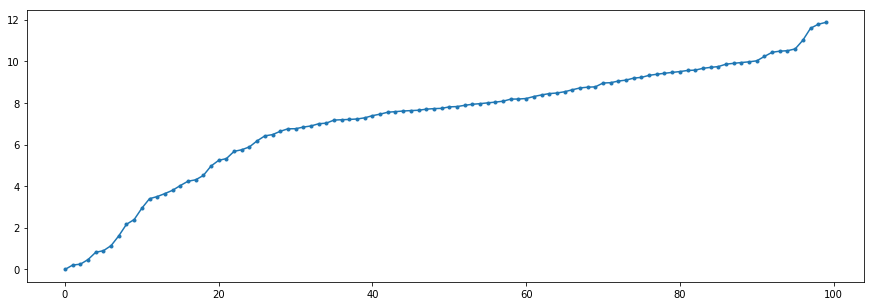

In [8]:
lamb, U = np.linalg.eigh(L.toarray())

#print(lamb)
plt.figure(figsize=(15, 5))
plt.plot(lamb, '.-');

1. Visualize the eigenvectors $u_\ell$ corresponding to the first eight non-zero eigenvalues $\lambda_\ell$.
2. Can you explain what you observe and relate it to the structure of the graph ?

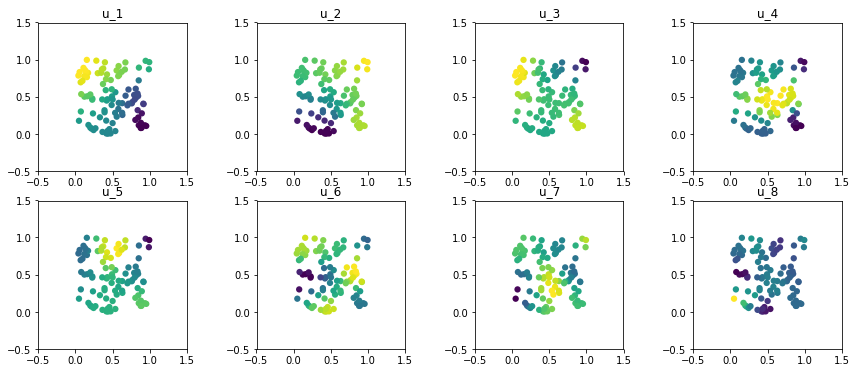

In [9]:
def scatter(ax, x):
    ax.scatter(X[:, 0], X[:, 1], c=x, s=40, linewidths=0)
    ax.set_xlim(lim1, lim2)
    ax.set_ylim(lim1, lim2)
    ax.set_aspect('equal')

fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    u = U[:, i+1]
    scatter(ax, u)
    ax.set_title('u_{}'.format(i+1))

## 3 Graph Signals

1. Let $f(u)$ be a positive and non-increasing function of $u$.
2. Compute the graph signal $x$ whose graph Fourier transform satisfies $\hat{x}(\ell) = f(\lambda_\ell)$.
3. Visualize the result.
4. Can you interpret it ? How does the choice of $f$ influence the result ? 

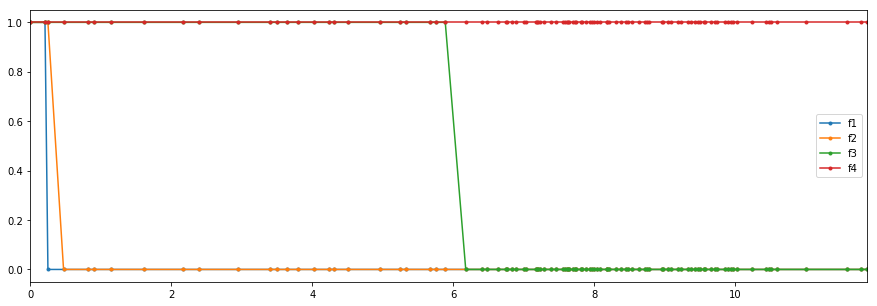

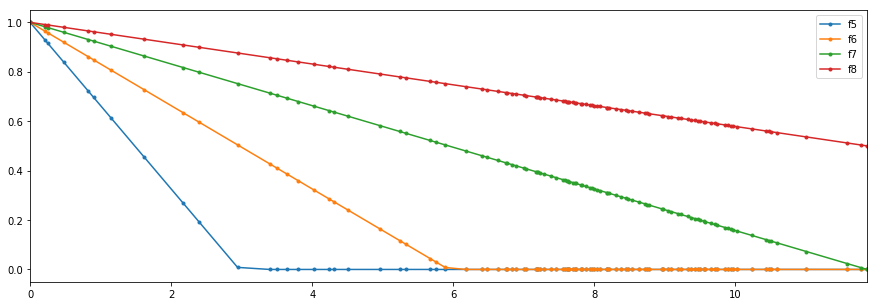

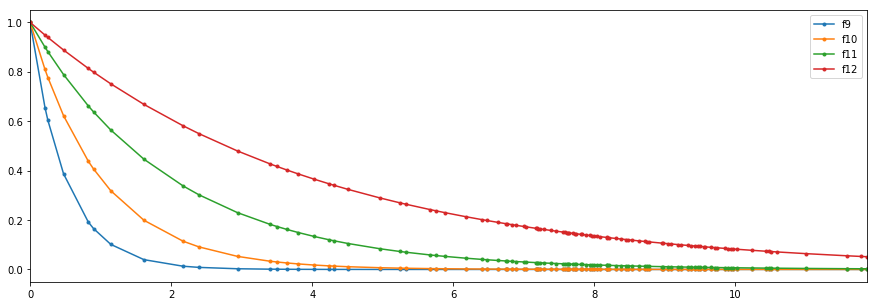

In [10]:
def f1(u, a=2):
    y = np.zeros(n)
    y[:a] = 1
    return y
def f2(u):
    return f1(u, a=3)
def f3(u):
    return f1(u, a=n//4)
def f4(u):
    return f1(u, a=n)

def f5(u, m=4):
    return np.maximum(1 - m * u / u[-1], 0)
def f6(u):
    return f5(u, 2)
def f7(u):
    return f5(u, 1)
def f8(u):
    return f5(u, 1/2)

def f9(u, a=1/2):
    return np.exp(-u / a)
def f10(u):
    return f9(u, a=1)
def f11(u):
    return f9(u, a=2)
def f12(u):
    return f9(u, a=4)

def plot(F):
    plt.figure(figsize=(15, 5))
    for f in F:
        plt.plot(lamb, eval(f)(lamb), '.-', label=f)
    plt.xlim(0, lamb[-1])
    plt.legend()

F = ['f{}'.format(i+1) for i in range(12)]
plot(F[0:4])
plot(F[4:8])
plot(F[8:12])

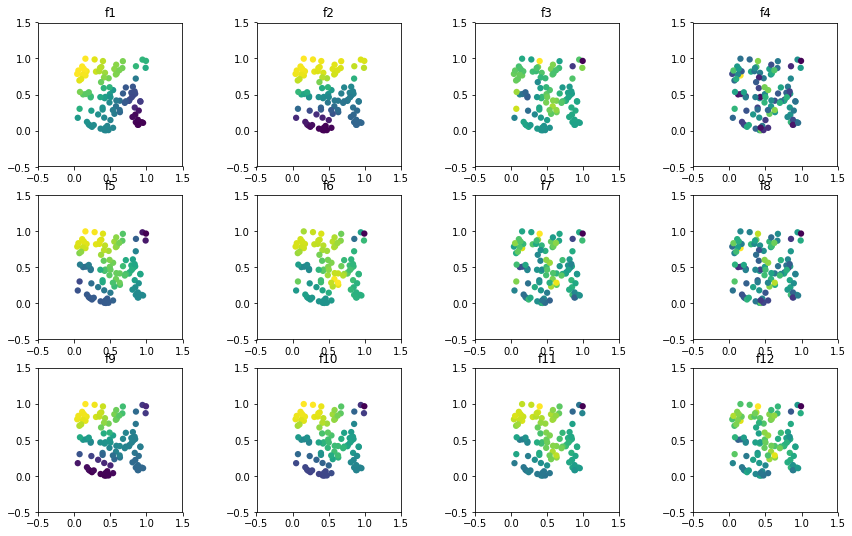

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
for f, ax in zip(F, axes.flatten()):
    xhat = eval(f)(lamb)
    x = U.dot(xhat)  # U @ xhat
    #x = U.dot(xhat * U.T[:,2])
    scatter(ax, x)
    ax.set_title(f)